In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_data = pd.read_csv('/Users/arnav/Downloads/fashion-mnist_train.csv')
test_data = pd.read_csv('/Users/arnav/Downloads/fashion-mnist_test.csv')

In [41]:
# Separate features and labels
def preprocess_data(data):
    labels = data['label'].values
    features = data.drop('label', axis=1).values / 255.0  # Normalize pixel values
    return features, labels

x_train, y_train = preprocess_data(train_data)
x_test, y_test = preprocess_data(test_data)

# One-hot encode the labels
def one_hot_encode(labels, num_classes=10):
    encoded = np.zeros((labels.size, num_classes))
    encoded[np.arange(labels.size), labels] = 1
    return encoded

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

In [42]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Xavier/Glorot initialization
        def xavier_init(size):
            input_dim, output_dim = size
            limit = np.sqrt(6 / (input_dim + output_dim))
            return np.random.uniform(-limit, limit, size)

        # Initialize weights and biases for two hidden layers
        self.weights_input_hidden1 = xavier_init((input_size, hidden_size1))
        self.bias_hidden1 = np.zeros(hidden_size1)
        self.weights_hidden1_hidden2 = xavier_init((hidden_size1, hidden_size2))
        self.bias_hidden2 = np.zeros(hidden_size2)
        self.weights_hidden2_output = xavier_init((hidden_size2, output_size))
        self.bias_output = np.zeros(output_size)

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Adam optimizer variables
        self.m_weights_input_hidden1 = np.zeros_like(self.weights_input_hidden1)
        self.v_weights_input_hidden1 = np.zeros_like(self.weights_input_hidden1)
        self.m_bias_hidden1 = np.zeros_like(self.bias_hidden1)
        self.v_bias_hidden1 = np.zeros_like(self.bias_hidden1)

        self.m_weights_hidden1_hidden2 = np.zeros_like(self.weights_hidden1_hidden2)
        self.v_weights_hidden1_hidden2 = np.zeros_like(self.weights_hidden1_hidden2)
        self.m_bias_hidden2 = np.zeros_like(self.bias_hidden2)
        self.v_bias_hidden2 = np.zeros_like(self.bias_hidden2)

        self.m_weights_hidden2_output = np.zeros_like(self.weights_hidden2_output)
        self.v_weights_hidden2_output = np.zeros_like(self.weights_hidden2_output)
        self.m_bias_output = np.zeros_like(self.bias_output)
        self.v_bias_output = np.zeros_like(self.bias_output)

        self.t = 0  # Time step for Adam

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred, lambda_reg=0.01):
        epsilon = 1e-12  # To avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        l2_reg = (lambda_reg / 2) * (
            np.sum(np.square(self.weights_input_hidden1)) +
            np.sum(np.square(self.weights_hidden1_hidden2)) +
            np.sum(np.square(self.weights_hidden2_output))
        )
        return cross_entropy + l2_reg

    def forward(self, x):
        # First hidden layer
        self.hidden_input1 = np.dot(x, self.weights_input_hidden1) + self.bias_hidden1
        self.hidden_output1 = self.relu(self.hidden_input1)

        # Second hidden layer
        self.hidden_input2 = np.dot(self.hidden_output1, self.weights_hidden1_hidden2) + self.bias_hidden2
        self.hidden_output2 = self.relu(self.hidden_input2)

        # Output layer
        self.final_input = np.dot(self.hidden_output2, self.weights_hidden2_output) + self.bias_output
        self.output = self.softmax(self.final_input)
        return self.output

    def backward(self, x, y, lambda_reg=0.01):
        # Output layer error
        output_error = self.output - y

        # Second hidden layer error
        hidden_error2 = np.dot(output_error, self.weights_hidden2_output.T) * self.relu_derivative(self.hidden_input2)

        # First hidden layer error
        hidden_error1 = np.dot(hidden_error2, self.weights_hidden1_hidden2.T) * self.relu_derivative(self.hidden_input1)

        # Update weights and biases with Adam optimizer
        self.t += 1

        # Update weights and biases for output layer
        grad_weights_hidden2_output = np.dot(self.hidden_output2.T, output_error) / x.shape[0] + lambda_reg * self.weights_hidden2_output
        grad_bias_output = np.mean(output_error, axis=0)

        self.m_weights_hidden2_output = self.beta1 * self.m_weights_hidden2_output + (1 - self.beta1) * grad_weights_hidden2_output
        self.v_weights_hidden2_output = self.beta2 * self.v_weights_hidden2_output + (1 - self.beta2) * np.square(grad_weights_hidden2_output)
        m_hat_weights_hidden2_output = self.m_weights_hidden2_output / (1 - self.beta1 ** self.t)
        v_hat_weights_hidden2_output = self.v_weights_hidden2_output / (1 - self.beta2 ** self.t)
        self.weights_hidden2_output -= self.learning_rate * m_hat_weights_hidden2_output / (np.sqrt(v_hat_weights_hidden2_output) + self.epsilon)

        self.m_bias_output = self.beta1 * self.m_bias_output + (1 - self.beta1) * grad_bias_output
        self.v_bias_output = self.beta2 * self.v_bias_output + (1 - self.beta2) * np.square(grad_bias_output)
        m_hat_bias_output = self.m_bias_output / (1 - self.beta1 ** self.t)
        v_hat_bias_output = self.v_bias_output / (1 - self.beta2 ** self.t)
        self.bias_output -= self.learning_rate * m_hat_bias_output / (np.sqrt(v_hat_bias_output) + self.epsilon)

        # Update weights and biases for second hidden layer
        grad_weights_hidden1_hidden2 = np.dot(self.hidden_output1.T, hidden_error2) / x.shape[0] + lambda_reg * self.weights_hidden1_hidden2
        grad_bias_hidden2 = np.mean(hidden_error2, axis=0)

        self.m_weights_hidden1_hidden2 = self.beta1 * self.m_weights_hidden1_hidden2 + (1 - self.beta1) * grad_weights_hidden1_hidden2
        self.v_weights_hidden1_hidden2 = self.beta2 * self.v_weights_hidden1_hidden2 + (1 - self.beta2) * np.square(grad_weights_hidden1_hidden2)
        m_hat_weights_hidden1_hidden2 = self.m_weights_hidden1_hidden2 / (1 - self.beta1 ** self.t)
        v_hat_weights_hidden1_hidden2 = self.v_weights_hidden1_hidden2 / (1 - self.beta2 ** self.t)
        self.weights_hidden1_hidden2 -= self.learning_rate * m_hat_weights_hidden1_hidden2 / (np.sqrt(v_hat_weights_hidden1_hidden2) + self.epsilon)

        self.m_bias_hidden2 = self.beta1 * self.m_bias_hidden2 + (1 - self.beta1) * grad_bias_hidden2
        self.v_bias_hidden2 = self.beta2 * self.v_bias_hidden2 + (1 - self.beta2) * np.square(grad_bias_hidden2)
        m_hat_bias_hidden2 = self.m_bias_hidden2 / (1 - self.beta1 ** self.t)
        v_hat_bias_hidden2 = self.v_bias_hidden2 / (1 - self.beta2 ** self.t)
        self.bias_hidden2 -= self.learning_rate * m_hat_bias_hidden2 / (np.sqrt(v_hat_bias_hidden2) + self.epsilon)

        # Update weights and biases for first hidden layer
        grad_weights_input_hidden1 = np.dot(x.T, hidden_error1) / x.shape[0] + lambda_reg * self.weights_input_hidden1
        grad_bias_hidden1 = np.mean(hidden_error1, axis=0)

        self.m_weights_input_hidden1 = self.beta1 * self.m_weights_input_hidden1 + (1 - self.beta1) * grad_weights_input_hidden1
        self.v_weights_input_hidden1 = self.beta2 * self.v_weights_input_hidden1 + (1 - self.beta2) * np.square(grad_weights_input_hidden1)
        m_hat_weights_input_hidden1 = self.m_weights_input_hidden1 / (1 - self.beta1 ** self.t)
        v_hat_weights_input_hidden1 = self.v_weights_input_hidden1 / (1 - self.beta2 ** self.t)
        self.weights_input_hidden1 -= self.learning_rate * m_hat_weights_input_hidden1 / (np.sqrt(v_hat_weights_input_hidden1) + self.epsilon)

        self.m_bias_hidden1 = self.beta1 * self.m_bias_hidden1 + (1 - self.beta1) * grad_bias_hidden1
        self.v_bias_hidden1 = self.beta2 * self.v_bias_hidden1 + (1 - self.beta2) * np.square(grad_bias_hidden1)
        m_hat_bias_hidden1 = self.m_bias_hidden1 / (1 - self.beta1 ** self.t)
        v_hat_bias_hidden1 = self.v_bias_hidden1 / (1 - self.beta2 ** self.t)
        self.bias_hidden1 -= self.learning_rate * m_hat_bias_hidden1 / (np.sqrt(v_hat_bias_hidden1) + self.epsilon)

    def train(self, x, y, x_val, y_val, epochs, batch_size, patience=5):
        loss_history, val_loss_history = [], []
        accuracy_history, val_accuracy_history = [], []
        best_loss = float('inf')
        no_improvement = 0

        for epoch in range(epochs):
            # Learning rate scheduling
            if epoch % 20 == 0 and epoch != 0:
                self.learning_rate *= 0.5  # Reduce learning rate by 50% every 20 epochs

            # Mini-batch training
            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                self.forward(x_batch)
                self.backward(x_batch, y_batch)

            # Calculate validation loss and accuracy
            val_predictions = self.forward(x_val)
            val_loss = self.cross_entropy_loss(y_val, val_predictions)
            val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_val, axis=1))

            # Early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                no_improvement = 0
            else:
                no_improvement += 1

            if no_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            # Calculate training loss and accuracy
            predictions = self.forward(x)
            loss = self.cross_entropy_loss(y, predictions)
            accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))

            # Store history
            loss_history.append(loss)
            val_loss_history.append(val_loss)
            accuracy_history.append(accuracy)
            val_accuracy_history.append(val_accuracy)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {self.learning_rate:.4f}")

        # Plot training progress
        self.plot_training_progress(loss_history, val_loss_history, accuracy_history, val_accuracy_history)

    def plot_training_progress(self, loss_history, val_loss_history, accuracy_history, val_accuracy_history):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(loss_history, label='Training Loss')
        plt.plot(val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracy_history, label='Training Accuracy')
        plt.plot(val_accuracy_history, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

Epoch 1/50, Loss: 0.9512, Val Loss: 0.9683, Accuracy: 0.8216, Val Accuracy: 0.8163, LR: 0.0010
Epoch 2/50, Loss: 0.7832, Val Loss: 0.8015, Accuracy: 0.8234, Val Accuracy: 0.8184, LR: 0.0010
Epoch 3/50, Loss: 0.7427, Val Loss: 0.7612, Accuracy: 0.8240, Val Accuracy: 0.8184, LR: 0.0010
Epoch 4/50, Loss: 0.7232, Val Loss: 0.7415, Accuracy: 0.8283, Val Accuracy: 0.8223, LR: 0.0010
Epoch 5/50, Loss: 0.7118, Val Loss: 0.7294, Accuracy: 0.8301, Val Accuracy: 0.8242, LR: 0.0010
Epoch 6/50, Loss: 0.7044, Val Loss: 0.7219, Accuracy: 0.8325, Val Accuracy: 0.8277, LR: 0.0010
Epoch 7/50, Loss: 0.6997, Val Loss: 0.7170, Accuracy: 0.8327, Val Accuracy: 0.8295, LR: 0.0010
Epoch 8/50, Loss: 0.6934, Val Loss: 0.7107, Accuracy: 0.8351, Val Accuracy: 0.8299, LR: 0.0010
Epoch 9/50, Loss: 0.6881, Val Loss: 0.7056, Accuracy: 0.8380, Val Accuracy: 0.8328, LR: 0.0010
Epoch 10/50, Loss: 0.6829, Val Loss: 0.7006, Accuracy: 0.8405, Val Accuracy: 0.8344, LR: 0.0010
Epoch 11/50, Loss: 0.6803, Val Loss: 0.6981, Accu

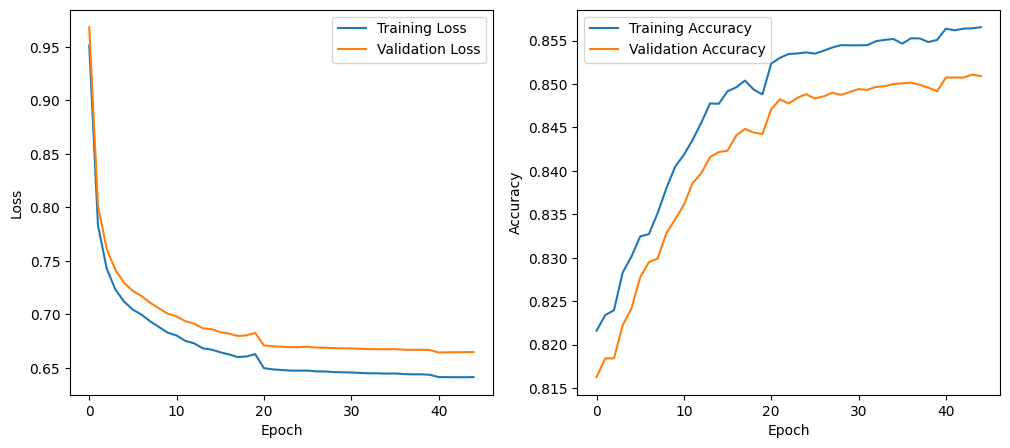

In [43]:
# Initialize the neural network with two hidden layers and Adam optimizer
input_size = x_train.shape[1]
hidden_size1 = 256  # First hidden layer
hidden_size2 = 128  # Second hidden layer
output_size = 10
learning_rate = 0.001  # Reduced learning rate

nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, learning_rate)

# Split training data into training and validation sets
split_ratio = 0.8
split_index = int(x_train.shape[0] * split_ratio)
x_train_split, x_val_split = x_train[:split_index], x_train[split_index:]
y_train_split, y_val_split = y_train_encoded[:split_index], y_train_encoded[split_index:]

# Train the model with increased epochs and batch size
nn.train(x_train_split, y_train_split, x_val_split, y_val_split, epochs=50, batch_size=128, patience=5)

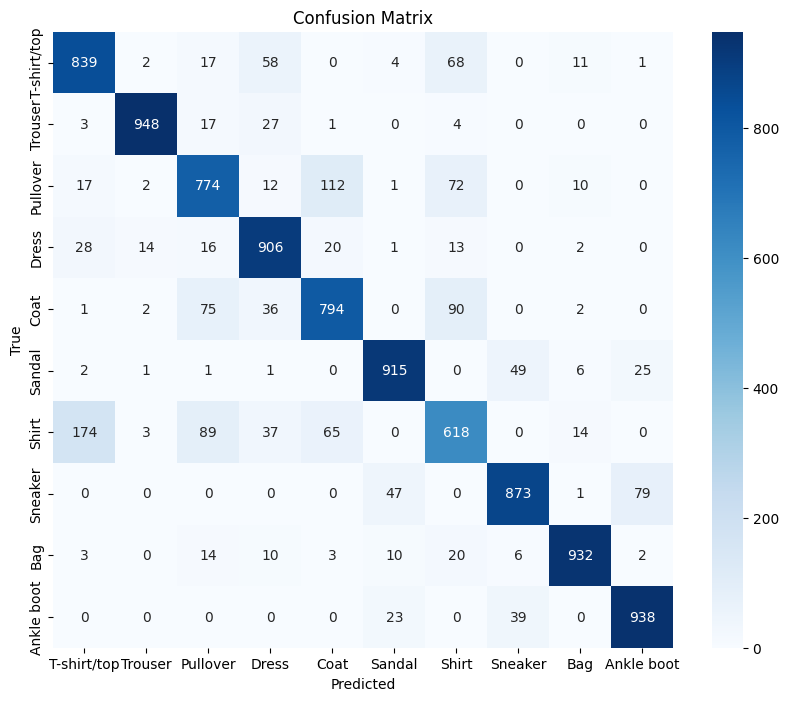

/var/folders/vx/j1ls1g1x55d1ztsmzm02h0xh0000gn/T/ipykernel_31583/824585571.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_accuracy, palette="viridis")


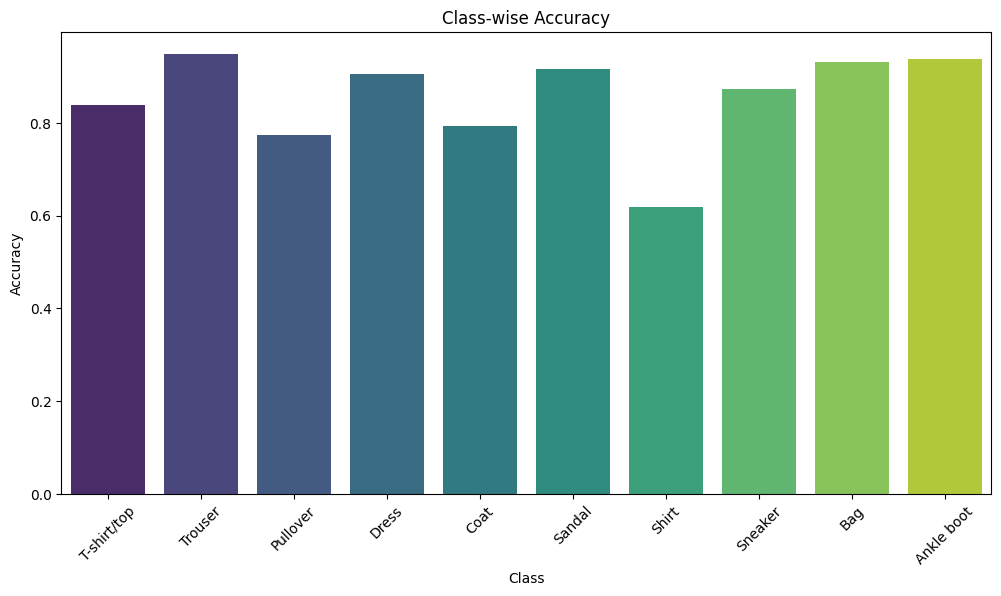

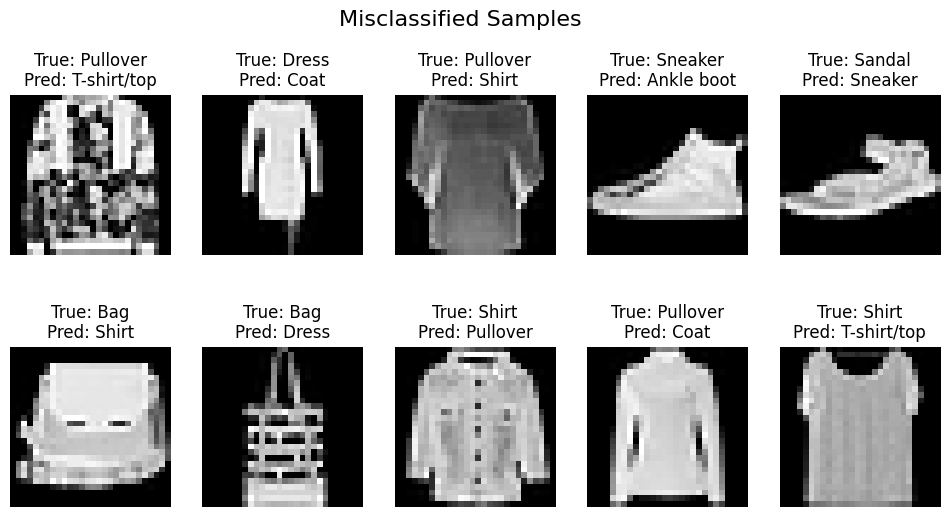

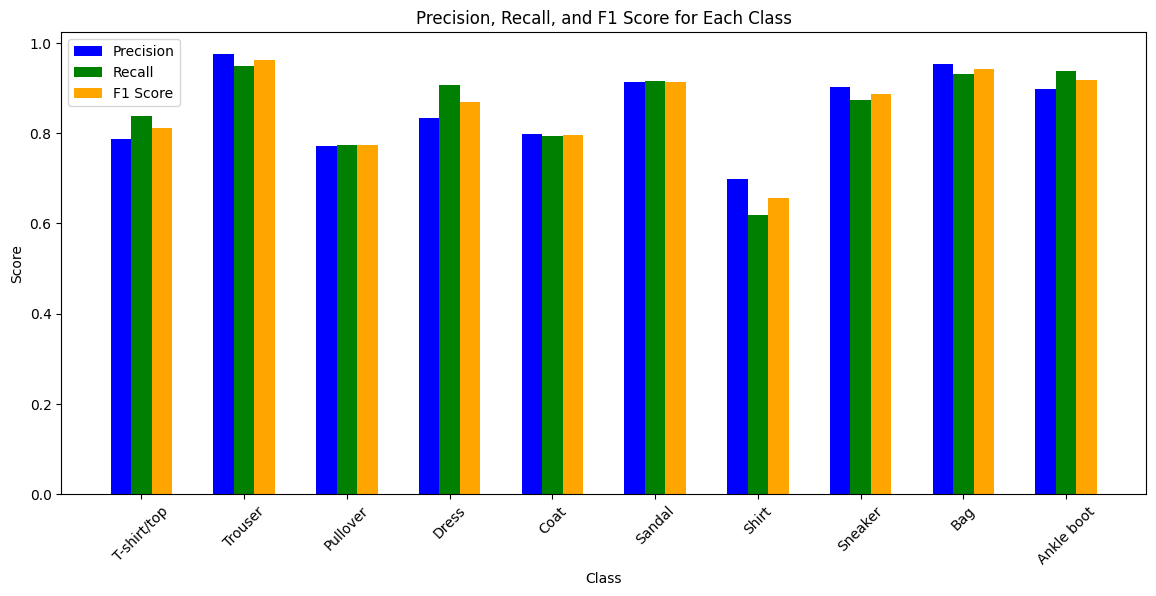

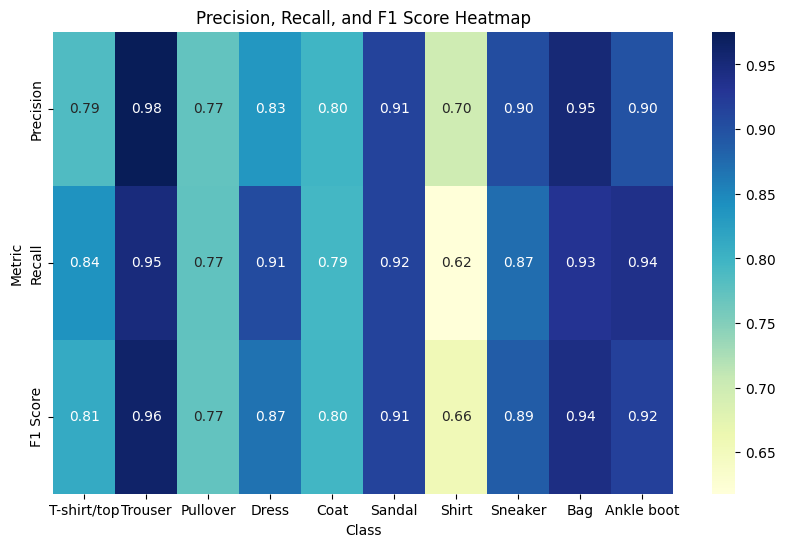

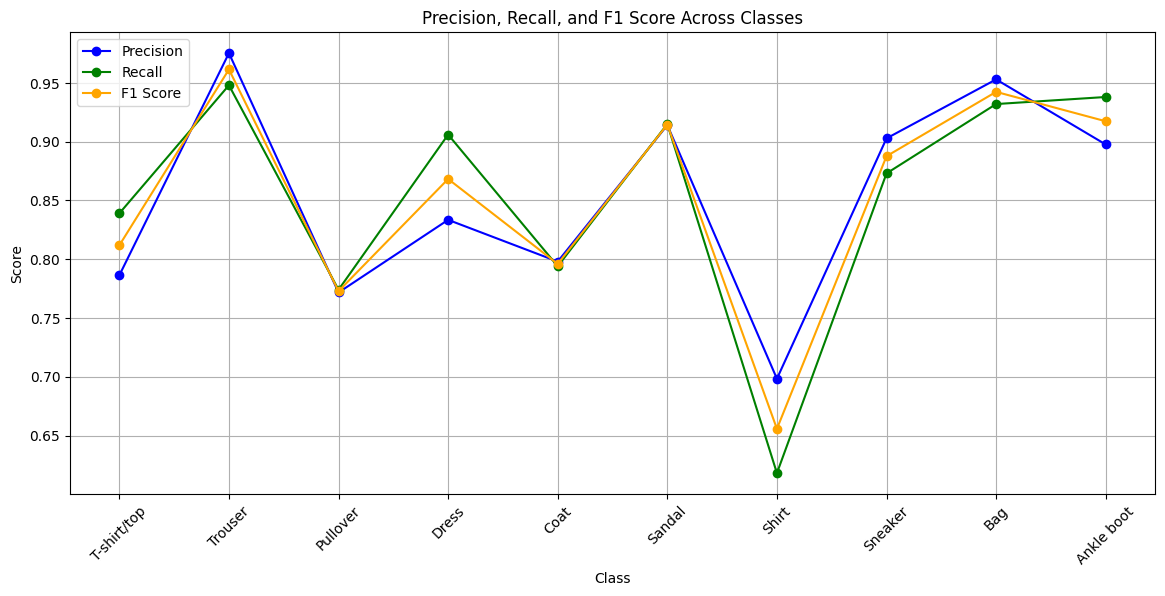

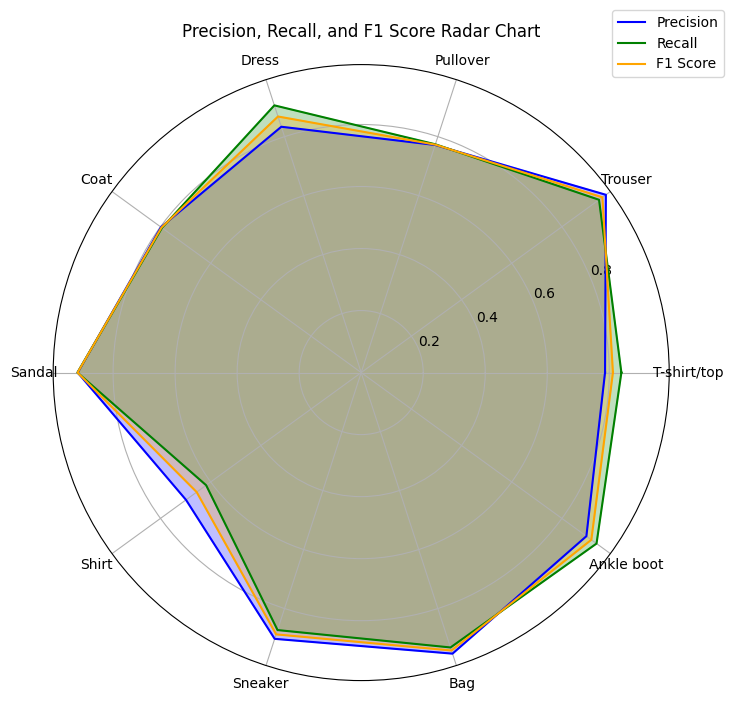

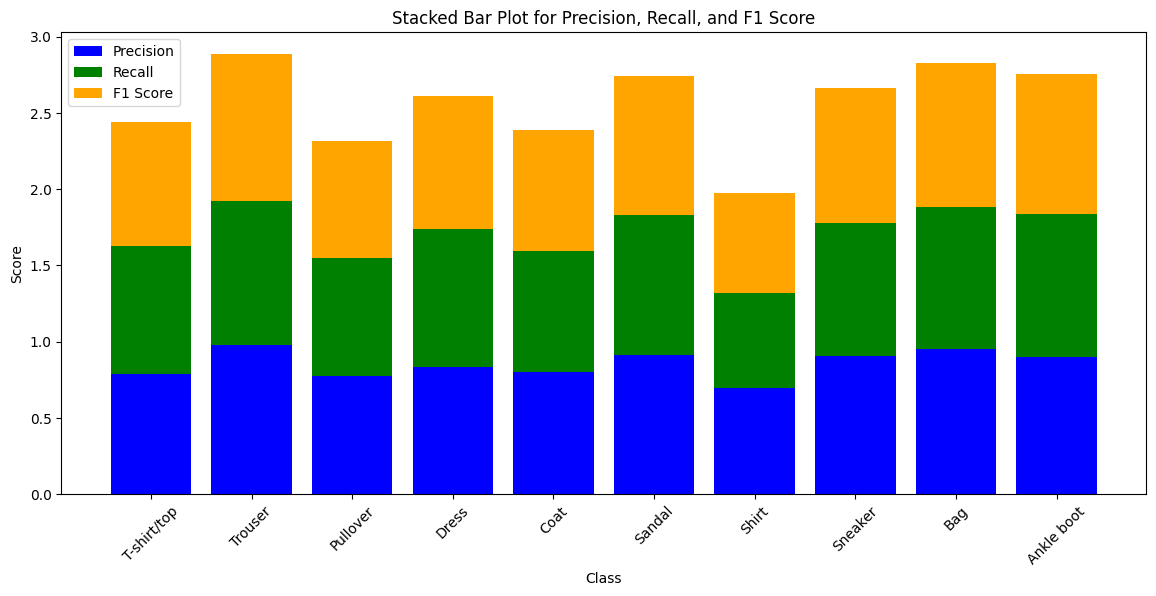

In [50]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Create a confusion matrix manually
    num_classes = len(class_names)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    
    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    return cm  # Return the confusion matrix for further calculations

# 2. Class-wise Accuracy
def plot_class_wise_accuracy(y_true, y_pred, class_names):
    num_classes = len(class_names)
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    for true_label, pred_label in zip(y_true, y_pred):
        class_total[true_label] += 1
        if true_label == pred_label:
            class_correct[true_label] += 1
    
    class_accuracy = class_correct / class_total
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_names, y=class_accuracy, palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Class-wise Accuracy")
    plt.xticks(rotation=45)
    plt.show()

# 3. Misclassified Samples
def plot_misclassified_samples(x, y_true, y_pred, class_names, num_samples=10):
    misclassified_indices = np.where(y_true != y_pred)[0]
    misclassified_samples = misclassified_indices[:num_samples]
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(misclassified_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[idx].reshape(28, 28), cmap="gray")
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis("off")
    plt.suptitle("Misclassified Samples", fontsize=16)
    plt.show()

# 4. Calculate Precision, Recall, and F1 Score
def calculate_metrics(cm, class_names):
    num_classes = len(class_names)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for i in range(num_classes):
        # True Positives (TP)
        TP = cm[i, i]
        # False Positives (FP)
        FP = np.sum(cm[:, i]) - TP
        # False Negatives (FN)
        FN = np.sum(cm[i, :]) - TP
        
        # Precision = TP / (TP + FP)
        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
        # Recall = TP / (TP + FN)
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
    
    return precision, recall, f1

# 5. Bar Plot for Precision, Recall, and F1 Score
def plot_metrics_bar(precision, recall, f1, class_names):
    x = np.arange(len(class_names))  # Class labels
    width = 0.2  # Width of the bars

    plt.figure(figsize=(14, 6))
    plt.bar(x - width, precision, width, label="Precision", color="blue")
    plt.bar(x, recall, width, label="Recall", color="green")
    plt.bar(x + width, f1, width, label="F1 Score", color="orange")

    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1 Score for Each Class")
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.show()

# 6. Heatmap for Precision, Recall, and F1 Score
def plot_metrics_heatmap(precision, recall, f1, class_names):
    metrics = np.array([precision, recall, f1])
    metric_names = ["Precision", "Recall", "F1 Score"]

    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_names, yticklabels=metric_names)
    plt.xlabel("Class")
    plt.ylabel("Metric")
    plt.title("Precision, Recall, and F1 Score Heatmap")
    plt.show()

# 7. Line Plot for Precision, Recall, and F1 Score
def plot_metrics_line(precision, recall, f1, class_names):
    x = np.arange(len(class_names))

    plt.figure(figsize=(14, 6))
    plt.plot(x, precision, marker="o", label="Precision", color="blue")
    plt.plot(x, recall, marker="o", label="Recall", color="green")
    plt.plot(x, f1, marker="o", label="F1 Score", color="orange")

    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1 Score Across Classes")
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# 8. Radar Chart for Precision, Recall, and F1 Score
def plot_radar_chart(precision, recall, f1, class_names):
    num_classes = len(class_names)
    angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    def add_radar_plot(values, label, color):
        values = np.append(values, values[0])  # Close the circle
        ax.plot(angles, values, label=label, color=color)
        ax.fill(angles, values, color=color, alpha=0.25)

    add_radar_plot(precision, "Precision", "blue")
    add_radar_plot(recall, "Recall", "green")
    add_radar_plot(f1, "F1 Score", "orange")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_names)
    ax.set_title("Precision, Recall, and F1 Score Radar Chart", pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.show()

# 9. Stacked Bar Plot for Precision, Recall, and F1 Score
def plot_stacked_bar(precision, recall, f1, class_names):
    x = np.arange(len(class_names))

    plt.figure(figsize=(14, 6))
    plt.bar(x, precision, label="Precision", color="blue")
    plt.bar(x, recall, bottom=precision, label="Recall", color="green")
    plt.bar(x, f1, bottom=precision + recall, label="F1 Score", color="orange")

    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.title("Stacked Bar Plot for Precision, Recall, and F1 Score")
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.show()

# Class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Generate predictions on the test set
y_test_pred = np.argmax(nn.forward(x_test), axis=1)

# Plot the visualizations
cm = plot_confusion_matrix(y_test, y_test_pred, class_names)
plot_class_wise_accuracy(y_test, y_test_pred, class_names)
plot_misclassified_samples(x_test, y_test, y_test_pred, class_names)

# Calculate precision, recall, and F1 score
precision, recall, f1 = calculate_metrics(cm, class_names)

# Additional visualizations
plot_metrics_bar(precision, recall, f1, class_names)
plot_metrics_heatmap(precision, recall, f1, class_names)
plot_metrics_line(precision, recall, f1, class_names)
plot_radar_chart(precision, recall, f1, class_names)
plot_stacked_bar(precision, recall, f1, class_names)

Test Accuracy: 0.8537


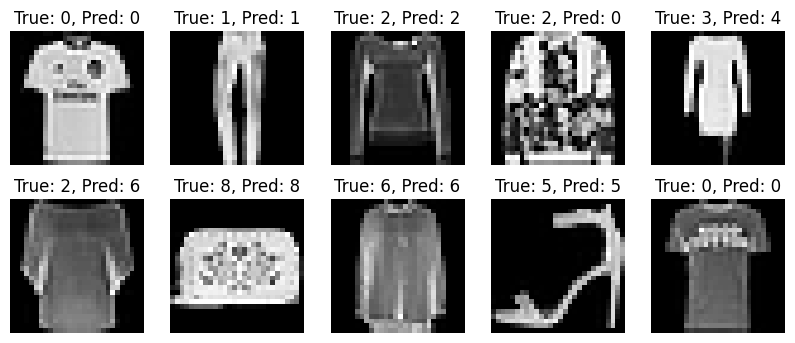

In [45]:
# Evaluate the model on the test set
predictions = np.argmax(nn.forward(x_test), axis=1)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualization: Plot a few test images with predictions
def plot_samples(x, y, predictions, num_samples=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y[i]}, Pred: {predictions[i]}")
        plt.axis('off')
    plt.show()

plot_samples(x_test, y_test, predictions)